<a href="https://colab.research.google.com/github/ChoEChoU/PredictionOfPsychologicalPropensity/blob/main/aiContest4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#라이브러리

In [ ]:
import random
from datetime import datetime

import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import StratifiedKFold
from torch import nn, optim
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from tqdm import tqdm

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from string import ascii_lowercase
from itertools import combinations

import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import  GradientBoostingClassifier

from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from IPython.display import Image

#데이터로드 & 데이터 살피기

In [ ]:
train = pd.read_csv('train.csv', index_col = 0)
test = pd.read_csv('test.csv', index_col = 0)
train.head()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,engnat,age,hand,religion,orientation,voted,married,familysize,ASD,nerdiness
index,,,,,,,,,,,,,,,,,,,,,
0,1.0,5.0,5.0,5.0,1.0,4.0,5.0,5.0,1.0,3.0,...,1.0,20,2.0,12.0,4.0,2.0,1.0,4.0,2.0,1
1,4.0,4.0,4.0,4.0,4.0,5.0,4.0,4.0,3.0,3.0,...,1.0,49,1.0,2.0,1.0,1.0,2.0,4.0,2.0,1
2,4.0,5.0,5.0,4.0,3.0,5.0,5.0,5.0,4.0,4.0,...,2.0,43,1.0,2.0,2.0,2.0,3.0,4.0,2.0,1
3,4.0,4.0,4.0,2.0,4.0,3.0,3.0,5.0,3.0,4.0,...,1.0,17,2.0,1.0,1.0,2.0,1.0,2.0,2.0,1
4,4.0,4.0,4.0,4.0,3.0,3.0,4.0,2.0,3.0,4.0,...,2.0,18,2.0,12.0,1.0,2.0,1.0,1.0,2.0,0


In [ ]:
train.describe()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,engnat,age,hand,religion,orientation,voted,married,familysize,ASD,nerdiness
count,14959.000000,14931.000000,14950.000000,14929.000000,14962.000000,14952.000000,14924.000000,14952.000000,14944.000000,14928.000000,...,14953.000000,15000.000000,14953.000000,14755.000000,14601.000000,14915.000000,14918.000000,14681.000000,14911.000000,15000.000000
mean,3.972859,4.065702,4.222809,3.795499,3.856503,3.676364,4.183262,3.879013,3.915418,4.110598,...,1.346018,26.740867,1.185113,4.098340,1.847956,1.633121,1.179917,2.744091,1.938703,0.553533
std,1.095914,1.169681,1.023335,1.219940,1.195622,1.170986,1.059756,1.302081,1.117625,1.047617,...,0.475715,317.058436,0.481993,3.425699,1.223191,0.481969,0.465985,24.109344,0.239882,0.497142
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,13.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,3.000000,4.000000,4.000000,3.000000,3.000000,3.000000,4.000000,3.000000,3.000000,4.000000,...,1.000000,17.000000,1.000000,2.000000,1.000000,1.000000,1.000000,2.000000,2.000000,0.000000
50%,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,...,1.000000,20.000000,1.000000,2.000000,1.000000,2.000000,1.000000,2.000000,2.000000,1.000000
75%,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,2.000000,27.000000,1.000000,6.000000,2.000000,2.000000,1.000000,3.000000,2.000000,1.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,2.000000,38822.000000,3.000000,12.000000,5.000000,2.000000,3.000000,2919.000000,2.000000,1.000000


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15000 entries, 0 to 14999
Data columns (total 69 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Q1            14959 non-null  float64
 1   Q2            14931 non-null  float64
 2   Q3            14950 non-null  float64
 3   Q4            14929 non-null  float64
 4   Q5            14962 non-null  float64
 5   Q6            14952 non-null  float64
 6   Q7            14924 non-null  float64
 7   Q8            14952 non-null  float64
 8   Q9            14944 non-null  float64
 9   Q10           14928 non-null  float64
 10  Q11           14941 non-null  float64
 11  Q12           14933 non-null  float64
 12  Q13           14960 non-null  float64
 13  Q14           14964 non-null  float64
 14  Q15           14955 non-null  float64
 15  Q16           14967 non-null  float64
 16  Q17           14963 non-null  float64
 17  Q18           14937 non-null  float64
 18  Q19           14947 non-nu

In [ ]:
Answers = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5',
             'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 
             'Q11', 'Q12', 'Q13', 'Q14', 'Q15', 
             'Q16', 'Q17', 'Q18', 'Q19', 'Q20',
             'Q21', 'Q22', 'Q23', 'Q24', 'Q25', 'Q26']

remains = [ 'introelapse', 'testelapse', 'surveyelapse',
           'education', 'urban', 'gender', 'engnat', 'age',
           'hand', 'religion', 'orientation', 'voted', 'married', 'familysize', 'ASD', 'nerdiness'
]

TIPI = ['TIPI1', 'TIPI2', 'TIPI3', 'TIPI4', 'TIPI5',
             'TIPI6', 'TIPI7', 'TIPI8', 'TIPI9', 'TIPI10']

VCL = ['VCL1', 'VCL2', 'VCL3', 'VCL4', 'VCL5',
             'VCL6', 'VCL7', 'VCL8', 'VCL9', 'VCL10',
            'VCL11', 'VCL12', 'VCL13', 'VCL14', 'VCL15', 'VCL16']

In [ ]:
for col in train[Answers]:
    print(sorted(train[col].unique()))
print('_________________________________')
for col in train[remains]:
    print(sorted(train[col].unique()))
print('_________________________________')
for col in train[TIPI]:
    print(sorted(train[col].unique()))
print('_________________________________')
for col in train[VCL]:
    print(sorted(train[col].unique()))

[1.0, 2.0, 3.0, 4.0, 5.0, nan]
[1.0, 2.0, 3.0, 4.0, 5.0, nan]
[1.0, 2.0, 3.0, 4.0, 5.0, nan]
[1.0, 2.0, 3.0, 4.0, 5.0, nan]
[1.0, 2.0, 3.0, 4.0, 5.0, nan]
[1.0, 2.0, 3.0, 4.0, 5.0, nan]
[1.0, 2.0, 3.0, 4.0, 5.0, nan]
[1.0, 2.0, 3.0, 4.0, 5.0, nan]
[1.0, 2.0, 3.0, 4.0, 5.0, nan]
[1.0, 2.0, 3.0, 4.0, 5.0, nan]
[1.0, 2.0, 3.0, 4.0, 5.0, nan]
[1.0, 2.0, 3.0, 4.0, 5.0, nan]
[1.0, 2.0, 3.0, 4.0, 5.0, nan]
[1.0, 2.0, 3.0, 4.0, 5.0, nan]
[1.0, 2.0, 3.0, 4.0, 5.0, nan]
[1.0, 2.0, 3.0, 4.0, 5.0, nan]
[1.0, 2.0, 3.0, 4.0, 5.0, nan]
[1.0, 2.0, 3.0, 4.0, 5.0, nan]
[1.0, 2.0, 3.0, 4.0, 5.0, nan]
[1.0, 2.0, 3.0, 4.0, 5.0, nan]
[1.0, 2.0, 3.0, 4.0, 5.0, nan]
[1.0, 2.0, 3.0, 4.0, 5.0, nan]
[1.0, 2.0, 3.0, 4.0, 5.0, nan]
[1.0, 2.0, 3.0, 4.0, 5.0, nan]
[1.0, 2.0, 3.0, 4.0, 5.0, nan]
[1.0, 2.0, 3.0, 4.0, 5.0, nan]
_________________________________
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 

#결측치대체

In [ ]:
train[Answers].isnull().sum()

Q1     41
Q2     69
Q3     50
Q4     71
Q5     38
Q6     48
Q7     76
Q8     48
Q9     56
Q10    72
Q11    59
Q12    67
Q13    40
Q14    36
Q15    45
Q16    33
Q17    37
Q18    63
Q19    53
Q20    45
Q21    39
Q22    38
Q23    50
Q24    61
Q25    44
Q26    68
dtype: int64

In [ ]:
test[Answers].isnull().sum()

Q1     119
Q2     147
Q3     130
Q4     125
Q5      90
Q6     132
Q7     142
Q8     108
Q9     104
Q10    220
Q11    119
Q12    149
Q13     96
Q14    102
Q15    107
Q16     85
Q17     79
Q18    147
Q19     97
Q20    119
Q21    123
Q22     82
Q23    114
Q24    125
Q25    108
Q26    108
dtype: int64

In [ ]:
train = train.fillna(round(train.mean()))
test = test.fillna(round(test.mean()))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


#Over값대체

In [ ]:
train.age = train.age.apply(lambda x : train.age.mean() if x >= 100 else x)
train.familysize = train.familysize.apply(lambda x : 11 if x >= 11 else x)

In [ ]:
train.introelapse = train.introelapse.apply(lambda x : train.introelapse.mean() if x >= 100000 else x)
train.testelapse = train.testelapse.apply(lambda x : train.testelapse.mean() if x >= 100000 else x)
train.surveyelapse = train.surveyelapse.apply(lambda x : train.surveyelapse.mean() if x >= 500000 else x)

#마키아벨리즘

In [ ]:
eda_train = train.copy()

In [ ]:
Answers = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5',
             'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 
             'Q11', 'Q12', 'Q13', 'Q14', 'Q15', 
             'Q16', 'Q17', 'Q18', 'Q19', 'Q20',
             'Q21', 'Q22', 'Q23', 'Q24', 'Q25', 'Q26']

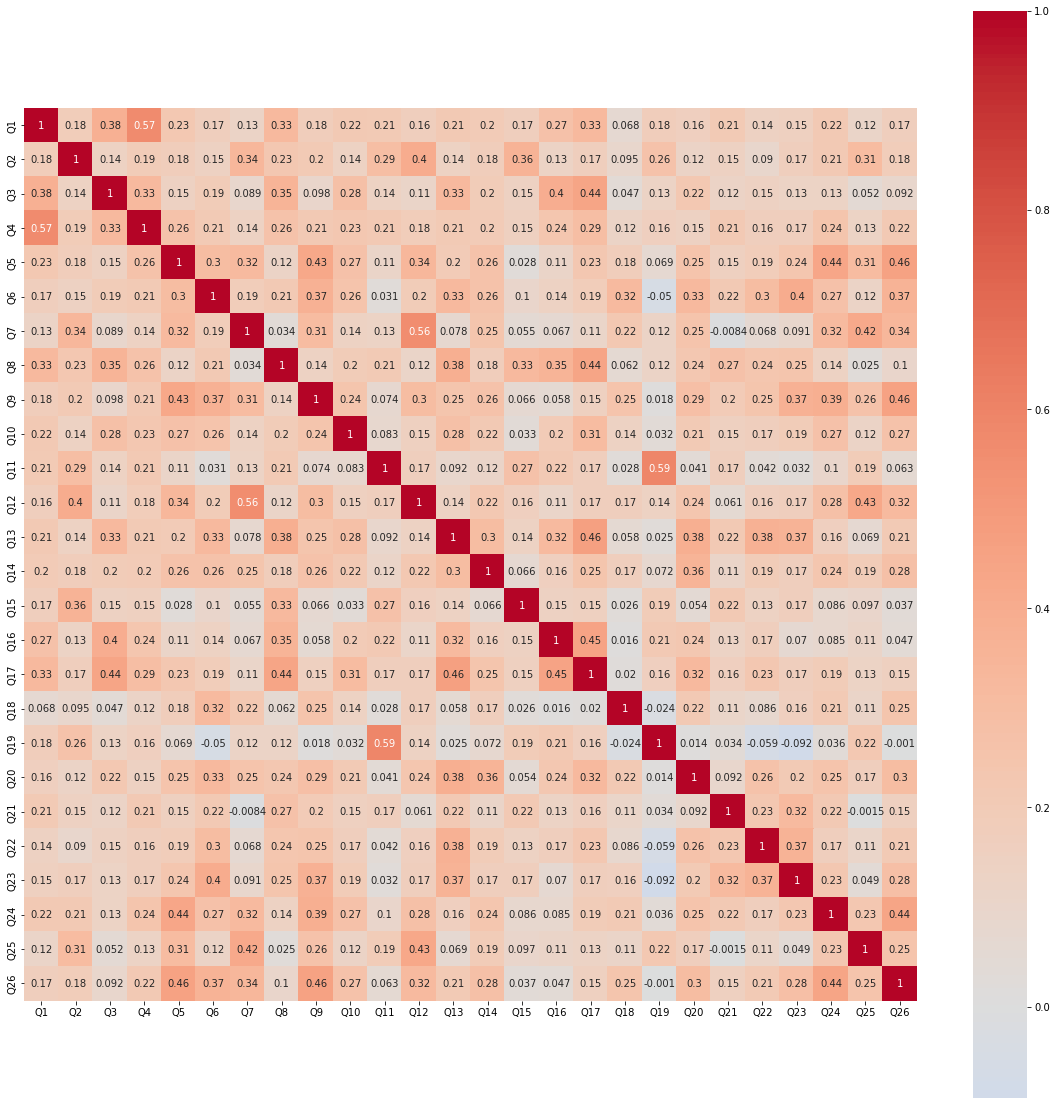

In [ ]:
|||correlations = eda_train[Answers].corr(method = 'spearman')
plt.figure(figsize = (20,20))
sns.heatmap(correlations, annot = True, cmap="coolwarm", square=True, center=0)

In [ ]:
correlations = eda_train[Answers_1].corr(method = 'spearman')
plt.figure(figsize = (20,20))
sns.heatmap(correlations, annot = True, cmap="coolwarm", square=True, center=0)

NameError: ignored

In [ ]:
correlations = eda_train[Answers_2].corr(method = 'spearman')
sns.heatmap(correlations, annot = True, cmap="coolwarm", square=True, center=0)

In [ ]:
train['Mach_score'] = train[Answers].sum(axis = 1)
test['Mach_score'] = test[Answers].sum(axis = 1)

In [ ]:
Tactics = ['Q1', 'Q2', 'Q3', 'Q6', 'Q7', 'Q10', 'Q12', 'Q15', 'Q16']
Views = ['Q4', 'Q5', 'Q8', 'Q11', 'Q13', 'Q14', 'Q17', 'Q18', 'Q20']
Morality = ['Q9', 'Q19']
sep = ['Tactics', 'Views', 'Morality', 'Mach_score', 'nerdiness']

In [ ]:
train['Mach_score'] = train[Answers].sum(axis = 1)
train['Tactics'] = train[Tactics].sum(axis = 1)
train['Views'] = train[Views].sum(axis = 1)
train['Morality'] = train[Morality].sum(axis = 1)

test['Mach_score'] = test[Answers].sum(axis = 1)
test['Tactics'] = test[Tactics].sum(axis = 1)
test['Views'] = test[Views].sum(axis = 1)
test['Morality'] = test[Morality].sum(axis = 1)

In [ ]:
correlations = eda_train[sep].corr(method = 'spearman')
sns.heatmap(correlations, annot = True, cmap="coolwarm", square=True, center=0)

In [ ]:
train = train.drop(Answers, axis=1)
test = test.drop(Answers, axis=1)

In [ ]:
train.describe()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,age,hand,religion,orientation,voted,married,familysize,ASD,nerdiness,Mach_score
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,...,15000.000000,15000.000000,15000.000000,15000.00000,15000.00000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,3.972933,4.065400,4.222067,3.796467,3.856867,3.677400,4.182333,3.879400,3.915733,4.110067,...,24.035279,1.184533,4.096733,1.85200,1.63520,1.178933,2.547800,1.939067,0.553533,96.209600
std,1.094416,1.166996,1.021709,1.217130,1.194128,1.169253,1.057148,1.300013,1.115549,1.045127,...,10.760767,0.481348,3.397628,1.20706,0.48139,0.464898,1.262202,0.239216,0.497142,15.159153
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,13.000000,1.000000,1.000000,1.00000,1.00000,1.000000,1.000000,1.000000,0.000000,26.000000
25%,3.000000,4.000000,4.000000,3.000000,3.000000,3.000000,4.000000,3.000000,3.000000,4.000000,...,17.000000,1.000000,2.000000,1.00000,1.00000,1.000000,2.000000,2.000000,0.000000,87.000000
50%,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,...,20.000000,1.000000,2.000000,1.00000,2.00000,1.000000,2.000000,2.000000,1.000000,97.000000
75%,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,27.000000,1.000000,6.000000,2.00000,2.00000,1.000000,3.000000,2.000000,1.000000,107.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,99.000000,3.000000,12.000000,5.00000,2.00000,3.000000,11.000000,2.000000,1.000000,130.000000


##one hot incoding

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
ohe = OneHotEncoder(sparse=False)

In [ ]:
for answer in train[Answers]:
    train_col = ohe.fit_transform(train[[answer]])
    train = pd.concat([train.drop(columns=[answer]),
           pd.DataFrame(train_col, columns=[answer + '_' + str(col) for col in ohe.categories_[0]])], axis=1)

In [ ]:
train.head()

,country,introelapse,testelapse,surveyelapse,TIPI1,TIPI2,TIPI3,TIPI4,TIPI5,TIPI6,...,Q25_1.0,Q25_2.0,Q25_3.0,Q25_4.0,Q25_5.0,Q26_1.0,Q26_2.0,Q26_3.0,Q26_4.0,Q26_5.0
0,USA,3,553,6,4.0,3.0,5.0,1.0,3.0,5.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,USA,5,85,120,4.0,2.0,3.0,5.0,3.0,2.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,NLD,9,108,100,1.0,2.0,3.0,1.0,5.0,5.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,USA,2,121,139,3.0,3.0,3.0,4.0,5.0,3.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,ITA,3,640,216,3.0,3.0,4.0,4.0,4.0,4.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
for answer in test[Answers]:
    test_col = ohe.fit_transform(test[[answer]])
    test = pd.concat([test.drop(columns=[answer]),
           pd.DataFrame(test_col, columns=[answer + '_' + str(col) for col in ohe.categories_[0]])], axis=1)

In [ ]:
test.head()

,country,introelapse,testelapse,surveyelapse,TIPI1,TIPI2,TIPI3,TIPI4,TIPI5,TIPI6,...,Q25_1.0,Q25_2.0,Q25_3.0,Q25_4.0,Q25_5.0,Q26_1.0,Q26_2.0,Q26_3.0,Q26_4.0,Q26_5.0
0,CHL,9,114,243,2.0,4.0,3.0,4.0,3.0,4.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,USA,18,107,206,1.0,4.0,3.0,5.0,4.0,5.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,IDN,4,87,191,3.0,3.0,4.0,3.0,4.0,4.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,AUS,2409,155,258,1.0,4.0,3.0,3.0,4.0,4.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,PHL,24,163,289,3.0,3.0,3.0,5.0,5.0,4.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


#TIPI

In [ ]:
tp1 = ['TIPI1', 'TIPI2', 'TIPI3', 'TIPI4', 'TIPI5',
             'TIPI6', 'TIPI7', 'TIPI8', 'TIPI9', 'TIPI10']

tp2 = ['TIPI2', 'TIPI4', 'TIPI6', 'TIPI8', 'TIPI10']

In [ ]:
train.loc[:,tp1] = train.loc[:,tp1].applymap(lambda x: 5 - x)
test.loc[:,tp1] = test.loc[:,tp1].applymap(lambda x: 5 - x)

train.loc[:,tp2] = train.loc[:,tp2].applymap(lambda x: 0 if x == 0 else 8 - x)
test.loc[:,tp2] = test.loc[:,tp2].applymap(lambda x: 0 if x == 0 else 8 - x)


train['Conscientiousness'] = (train.TIPI3 + train.TIPI8) / 2
train['Agreeableness'] = (train.TIPI7 + train.TIPI2) / 2 
train['Neuroticism'] = (train.TIPI9 + train.TIPI4) / 2 
train['Openness'] = (train.TIPI5 + train.TIPI10) / 2 
train['Extroversion'] = (train.TIPI1 + train.TIPI6) / 2

test['Conscientiousness'] = (test.TIPI3 + test.TIPI8) / 2
test['Agreeableness'] = (test.TIPI7 + test.TIPI2) / 2 
test['Neuroticism'] = (test.TIPI9 + test.TIPI4) / 2 
test['Openness'] = (test.TIPI5 + test.TIPI10) / 2 
test['Extroversion'] = (test.TIPI1 + test.TIPI6) / 2

In [ ]:
train = train.drop(tp1, axis=1)
test = test.drop(tp1, axis=1)

In [ ]:
train.describe()

,introelapse,testelapse,surveyelapse,TIPI1,TIPI2,TIPI3,TIPI4,TIPI5,TIPI6,TIPI7,...,VCL12_0,VCL12_1,VCL13_0,VCL13_1,VCL14_0,VCL14_1,VCL15_0,VCL15_1,VCL16_0,VCL16_1
count,15000.000000,15000.000000,1.500000e+04,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,...,15000.000000,15000.000000,15000.000000,15000.000000,15000.00000,15000.00000,15000.000000,15000.000000,15000.000000,15000.000000
mean,767.137733,387.965667,2.787959e+03,2.375533,5.298733,1.536333,4.754667,1.123333,4.292667,1.468800,...,0.789733,0.210267,0.238867,0.761133,0.09380,0.90620,0.040133,0.959867,0.019400,0.980600
std,13835.948037,8513.031610,1.785955e+05,1.148998,1.892652,0.997236,2.445338,0.909749,2.887900,1.013917,...,0.407512,0.407512,0.426405,0.426405,0.29156,0.29156,0.196278,0.196278,0.137931,0.137931
min,1.000000,1.000000,3.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,82.000000,1.260000e+02,2.000000,5.000000,1.000000,4.000000,0.000000,0.000000,1.000000,...,1.000000,0.000000,0.000000,1.000000,0.00000,1.00000,0.000000,1.000000,0.000000,1.000000
50%,10.000000,106.000000,1.640000e+02,2.000000,6.000000,2.000000,6.000000,1.000000,6.000000,2.000000,...,1.000000,0.000000,0.000000,1.000000,0.00000,1.00000,0.000000,1.000000,0.000000,1.000000
75%,36.000000,140.000000,2.170000e+02,3.000000,6.000000,2.000000,6.000000,2.000000,6.000000,2.000000,...,1.000000,0.000000,0.000000,1.000000,0.00000,1.00000,0.000000,1.000000,0.000000,1.000000
max,855030.000000,474572.000000,1.516699e+07,4.000000,7.000000,4.000000,7.000000,4.000000,7.000000,4.000000,...,1.000000,1.000000,1.000000,1.000000,1.00000,1.00000,1.000000,1.000000,1.000000,1.000000


In [ ]:
train[31:50].describe()

,introelapse,testelapse,surveyelapse,TIPI1,TIPI2,TIPI3,TIPI4,TIPI5,TIPI6,TIPI7,...,age_73.0,age_74.0,age_75.0,age_76.0,age_77.0,age_78.0,age_80.0,age_81.0,age_88.0,age_99.0
count,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,...,19.0,19.0,19.0,19.0,19.0,19.0,19.0,19.0,19.0,19.0
mean,393.684211,106.947368,292.105263,2.473684,4.894737,1.315789,5.052632,1.105263,4.157895,1.789474,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,1264.813823,38.316625,357.529470,0.904828,2.330826,0.820070,2.067572,0.994135,2.967662,1.031662,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,2.000000,59.000000,72.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,4.500000,76.000000,155.000000,2.000000,5.000000,1.000000,4.500000,0.000000,0.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,10.000000,93.000000,167.000000,2.000000,6.000000,2.000000,5.000000,1.000000,6.000000,2.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,181.000000,130.500000,247.000000,3.000000,6.000000,2.000000,6.500000,2.000000,6.000000,2.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,5558.000000,189.000000,1588.000000,4.000000,7.000000,2.000000,7.000000,3.000000,7.000000,4.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
train['age'].info()

KeyError: ignored

#VCL

In [ ]:
VCL = ['VCL1', 'VCL2', 'VCL3', 'VCL4', 'VCL5',
             'VCL6', 'VCL7', 'VCL8', 'VCL9', 'VCL10',
            'VCL11', 'VCL12', 'VCL13', 'VCL14', 'VCL15', 'VCL16'] #, 'Mach_score', 'nerdiness']
            #2, 3, 5, 6, 7, 8, 9, 11, 12, 13, 14

In [ ]:
for vcl in train[VCL]:
    train_col = ohe.fit_transform(train[[vcl]])
    train = pd.concat([train.drop(columns=[vcl]),
           pd.DataFrame(train_col, columns=[vcl + '_' + str(col) for col in ohe.categories_[0]])], axis=1)

In [ ]:
for vcl in test[VCL]:
    test_col = ohe.fit_transform(test[[vcl]])
    test = pd.concat([test.drop(columns=[vcl]),
           pd.DataFrame(test_col, columns=[vcl + '_' + str(col) for col in ohe.categories_[0]])], axis=1)

In [ ]:
correlations = eda_train[VCL].corr(method = 'spearman')
plt.figure(figsize = (20,20))
sns.heatmap(correlations, annot = True, cmap="coolwarm", square=True, center=0)

NameError: ignored

#특성중요도 분석

In [ ]:
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [ ]:
train_x = train.drop(['nerdiness', 'country'], axis = 1)
train_y = train['nerdiness']

In [ ]:
forest = RandomForestClassifier(n_estimators=100,random_state=0)

forest.fit(train_x, train_y)

RandomForestClassifier(random_state=0)

In [ ]:
print("특성 중요도 : \n{}".format(forest.feature_importances_))

특성 중요도 : 
[0.04988629 0.05753225 0.05919233 0.00218566 0.00368843 0.00914263
 0.00184927 0.00263435 0.00540939 0.00716376 0.00895791 0.00471114
 0.00268516 0.00822397 0.00756424 0.00756459 0.00469737 0.00219158
 0.00131793 0.01828621 0.01668841 0.01243199 0.00971638 0.04628426
 0.00953008 0.0306739  0.01982332 0.00989197 0.00789114 0.02646412
 0.00508787 0.13183431 0.10732568 0.09047321 0.03667556 0.03522434
 0.03536211 0.0372393  0.030213   0.0362846 ]


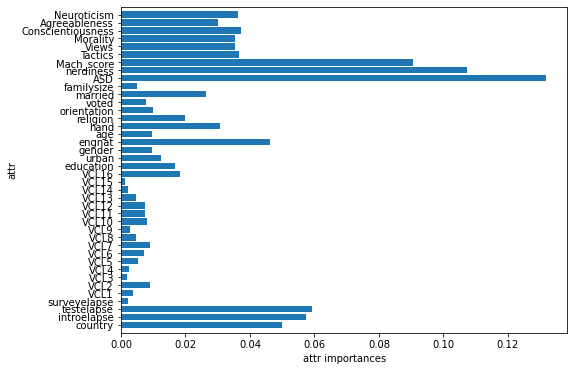

In [ ]:
def plot_feature_importances_cancer(model):

    plt.figure(figsize = (8,6))

    n_features = train_x.shape[1]

    plt.barh(range(n_features), model.feature_importances_, align='center')

    plt.yticks(np.arange(n_features), train.columns)

    plt.xlabel("attr importances")

    plt.ylabel("attr")

    plt.ylim(-1, n_features)

plt.show()



plot_feature_importances_cancer(forest)

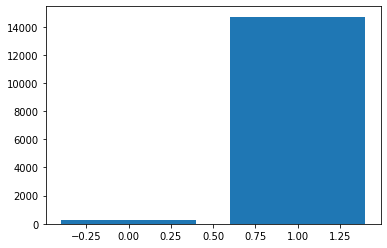

,VCL16,nerdiness
0,0,0.47079
1,1,0.55517


In [ ]:
plot_dict = train.loc[:,'VCL16'].value_counts().to_dict()
x_values = sorted(plot_dict.keys())
y_values = [plot_dict[x] for x in x_values]
plt.bar(x_values,y_values)
plt.show()
display(train.groupby('VCL16')['nerdiness'].agg('mean').reset_index())

In [ ]:
drop_list = ['surveyelapse', 'introelapse', 'testelapse']

In [ ]:
train = train.drop(drop_list, axis = 1)
test = test.drop(drop_list, axis = 1)

In [ ]:
test[:][21:31].describe()

,TIPI1,TIPI2,TIPI3,TIPI4,TIPI5,TIPI6,TIPI7,TIPI8,TIPI9,TIPI10,...,VCL12_0,VCL12_1,VCL13_0,VCL13_1,VCL14_0,VCL14_1,VCL15_0,VCL15_1,VCL16_0,VCL16_1
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.00000,10.000000,10.000000,10.000000,10.000000,...,10.0,10.0,10.000000,10.000000,10.0,10.0,10.0,10.0,10.0,10.0
mean,2.400000,5.600000,1.600000,5.600000,1.400000,2.50000,1.300000,5.100000,1.800000,4.900000,...,1.0,0.0,0.500000,0.500000,0.0,1.0,0.0,1.0,0.0,1.0
std,1.264911,0.699206,0.699206,0.966092,1.074968,3.24037,0.948683,1.969207,1.316561,0.875595,...,0.0,0.0,0.527046,0.527046,0.0,0.0,0.0,0.0,0.0,0.0
min,0.000000,4.000000,0.000000,4.000000,0.000000,0.00000,0.000000,0.000000,0.000000,4.000000,...,1.0,0.0,0.000000,0.000000,0.0,1.0,0.0,1.0,0.0,1.0
25%,2.000000,5.250000,1.250000,5.250000,0.250000,0.00000,1.000000,5.000000,1.000000,4.000000,...,1.0,0.0,0.000000,0.000000,0.0,1.0,0.0,1.0,0.0,1.0
50%,2.500000,6.000000,2.000000,6.000000,2.000000,0.00000,1.000000,6.000000,2.000000,5.000000,...,1.0,0.0,0.500000,0.500000,0.0,1.0,0.0,1.0,0.0,1.0
75%,3.000000,6.000000,2.000000,6.000000,2.000000,6.00000,2.000000,6.000000,2.750000,5.750000,...,1.0,0.0,1.000000,1.000000,0.0,1.0,0.0,1.0,0.0,1.0
max,4.000000,6.000000,2.000000,7.000000,3.000000,7.00000,3.000000,7.000000,4.000000,6.000000,...,1.0,0.0,1.000000,1.000000,0.0,1.0,0.0,1.0,0.0,1.0


In [ ]:
familysize = ['familysize']

In [ ]:
for familysize in train[familysize]:
    train_col = ohe.fit_transform(train[[familysize]])
    train = pd.concat([train.drop(columns=['familysize']),
           pd.DataFrame(train_col, columns=['familysize' + '_' + str(col) for col in ohe.categories_[0]])], axis=1)

In [ ]:
for familysize in test[familysize]:
    test_col = ohe.fit_transform(test[familysize])
    test = pd.concat([test.drop(columns=[familysize]),
           pd.DataFrame(test_col, columns=[familysize + '_' + str(col) for col in ohe.categories_[0]])], axis=1)

KeyError: ignored

In [ ]:
t.describe()

,TIPI1,TIPI2,TIPI3,TIPI4,TIPI5,TIPI6,TIPI7,TIPI8,TIPI9,TIPI10,...,VCL12_0,VCL12_1,VCL13_0,VCL13_1,VCL14_0,VCL14_1,VCL15_0,VCL15_1,VCL16_0,VCL16_1
count,35452.000000,35452.000000,35452.000000,35452.000000,35452.000000,35452.000000,35452.000000,35452.000000,35452.000000,35452.000000,...,35452.000000,35452.000000,35452.000000,35452.000000,35452.00000,35452.00000,35452.000000,35452.000000,35452.000000,35452.000000
mean,2.380373,5.302183,1.552606,4.767686,1.118865,4.320603,1.460566,5.030182,1.835016,4.947732,...,0.785626,0.214374,0.236178,0.763822,0.09266,0.90734,0.038587,0.961413,0.017573,0.982427
std,1.158842,1.869375,1.006353,2.433295,0.912540,2.881465,1.029095,2.104460,1.076101,1.228099,...,0.410393,0.410393,0.424739,0.424739,0.28996,0.28996,0.192612,0.192612,0.131395,0.131395
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,5.000000,1.000000,4.000000,0.000000,0.000000,1.000000,5.000000,1.000000,4.000000,...,1.000000,0.000000,0.000000,1.000000,0.00000,1.00000,0.000000,1.000000,0.000000,1.000000
50%,2.000000,6.000000,2.000000,6.000000,1.000000,6.000000,2.000000,6.000000,2.000000,5.000000,...,1.000000,0.000000,0.000000,1.000000,0.00000,1.00000,0.000000,1.000000,0.000000,1.000000
75%,3.000000,6.000000,2.000000,6.000000,2.000000,6.000000,2.000000,6.000000,2.000000,6.000000,...,1.000000,0.000000,0.000000,1.000000,0.00000,1.00000,0.000000,1.000000,0.000000,1.000000
max,4.000000,7.000000,4.000000,7.000000,4.000000,7.000000,4.000000,7.000000,4.000000,7.000000,...,1.000000,1.000000,1.000000,1.000000,1.00000,1.00000,1.000000,1.000000,1.000000,1.000000


#normalization

In [ ]:
neednor = ['age']

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train[neednor] = scaler.fit_transform(train[neednor])
test[neednor] = scaler.fit_transform(test[neednor])

#MODEL

In [ ]:
k_fold = KFold(n_splits = 5, shuffle = True, random_state = 42)

In [ ]:
train_x = train.drop(['nerdiness', 'country'], axis = 1)
train_y = train['nerdiness']

In [ ]:
clf1 = RandomForestClassifier(n_estimators=500)
clf2 = LGBMClassifier()
clf3 = GradientBoostingClassifier()
soft_vote  = VotingClassifier([('r1',clf1), ('r2', clf2), ('r3',clf3)], voting='soft')
soft_vote.fit(train_x, train_y)

VotingClassifier(estimators=[('r1', RandomForestClassifier(n_estimators=500)),
                             ('r2', LGBMClassifier()),
                             ('r3', GradientBoostingClassifier())],
                 voting='soft')

In [ ]:
test = test.drop(['country'], axis = 1)

KeyError: ignored

In [ ]:
model = soft_vote
pred_y = model.predict(test)

In [ ]:
pred_y

array([0, 1, 1, ..., 1, 1, 1])

In [ ]:
submission = pd.read_csv('sample_submission.csv')

submission

,index,nerdiness
0,0,-1
1,1,-1
2,2,-1
3,3,-1
4,4,-1
...,...,...
35447,35447,-1
35448,35448,-1
35449,35449,-1
35450,35450,-1


In [ ]:
submission["nerdiness"] = pred_y

In [ ]:
submission

,index,nerdiness
0,0,0
1,1,1
2,2,1
3,3,1
4,4,1
...,...,...
35447,35447,1
35448,35448,1
35449,35449,1
35450,35450,1


In [ ]:
submission.to_csv("baseline3.csv", index = False)

#autoML

In [ ]:
!pip install pycaret --user

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 320 kB 32.7 MB/s 
     |████████████████████████████████| 3.3 MB 63.2 MB/s 
     |████████████████████████████████| 6.8 MB 51.1 MB/s 
     |████████████████████████████████| 17.0 MB 71.6 MB/s 
     |████████████████████████████████| 134 kB 65.1 MB/s 
     |████████████████████████████████| 56 kB 5.1 MB/s 
     |████████████████████████████████| 636 kB 65.1 MB/s 
     |████████████████████████████████| 10.4 MB 62.2 MB/s 
     |████████████████████████████████| 167 kB 70.4 MB/s 
     |████████████████████████████████| 1.7 MB 62.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 262 kB 56.8 MB/s 
     |████████████████████████████████| 1.3 MB 57.5 MB/s 
     |██████████████████████████████

In [ ]:
!pip install Jinja2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install markupsafe==2.0.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 2.1.1
    Uninstalling MarkupSafe-2.1.1:
      Successfully uninstalled MarkupSafe-2.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling 3.2.0 requires markupsafe~=2.1.1, but you have markupsafe 2.0.1 which is incompatible.


In [ ]:
import jinja2
from pycaret.classification import *

In [ ]:
clf = setup(data = train, target = 'nerdiness', session_id=123)

,Description,Value
0,session_id,123
1,Target,nerdiness
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(15000, 192)"
5,Missing Values,True
6,Numeric Features,24
7,Categorical Features,167
8,Ordinal Features,False
9,High Cardinality Features,False


INFO:logs:create_model_container: 0
INFO:logs:master_model_container: 0
INFO:logs:display_container: 1
INFO:logs:Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True, features_todrop=[],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=[], target='nerdiness',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                numeric_st...
                ('scaling', 'passthrough'), ('P_transform', 'passthrough'),
                ('binn', 'passthrough'), ('rem_outliers', 'passthrough'),
                ('cluste

In [ ]:
best_3 = compare_models(sort = 'AUC', n_select = 3)
blended = blend_models(estimator_list = best_3)
pred_holdout = predict_model(blended)
final_model = finalize_model(blended)
predictions = predict_model(final_model, data = test)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7648,0.8559,0.8230,0.7689,0.7950,0.5198,0.5215
1,0.7705,0.8493,0.8265,0.7746,0.7997,0.5317,0.5332
2,0.7943,0.8777,0.8643,0.7859,0.8232,0.5785,0.5823
3,0.7752,0.8523,0.8247,0.7818,0.8027,0.5420,0.5431
4,0.7733,0.8572,0.8385,0.7722,0.8040,0.5364,0.5390
5,0.7905,0.8831,0.8675,0.7790,0.8208,0.5703,0.5751
6,0.7676,0.8369,0.8606,0.7541,0.8039,0.5218,0.5287
7,0.7648,0.8537,0.8210,0.7694,0.7943,0.5203,0.5218
8,0.7752,0.8704,0.8537,0.7666,0.8078,0.5391,0.5436


INFO:logs:create_model_container: 15
INFO:logs:master_model_container: 15
INFO:logs:display_container: 3
INFO:logs:VotingClassifier(estimators=[('et',
                              ExtraTreesClassifier(bootstrap=False,
                                                   ccp_alpha=0.0,
                                                   class_weight=None,
                                                   criterion='gini',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.7767,0.8576,0.8368,0.7766,0.8056,0.5442,0.5463


INFO:logs:Initializing finalize_model()
INFO:logs:finalize_model(estimator=VotingClassifier(estimators=[('et',
                              ExtraTreesClassifier(bootstrap=False,
                                                   ccp_alpha=0.0,
                                                   class_weight=None,
                                                   criterion='gini',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                       

In [ ]:
predictions

,country,TIPI1,TIPI2,TIPI3,TIPI4,TIPI5,TIPI6,TIPI7,TIPI8,TIPI9,...,VCL13_0,VCL13_1,VCL14_0,VCL14_1,VCL15_0,VCL15_1,VCL16_0,VCL16_1,Label,Score
0,CHL,3.0,7.0,2.0,7.0,2.0,7.0,2.0,6.0,2.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0,0.6646
1,USA,4.0,7.0,2.0,0.0,1.0,0.0,2.0,6.0,2.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1,0.7380
2,IDN,2.0,6.0,1.0,6.0,1.0,7.0,0.0,6.0,3.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1,0.8264
3,AUS,4.0,7.0,2.0,6.0,1.0,7.0,1.0,7.0,2.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1,0.5985
4,PHL,2.0,6.0,2.0,0.0,0.0,7.0,2.0,7.0,2.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1,0.7929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35447,USA,2.0,0.0,0.0,0.0,0.0,6.0,0.0,6.0,2.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1,0.8112
35448,GBR,2.0,6.0,0.0,0.0,2.0,0.0,0.0,6.0,4.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1,0.7096
35449,USA,4.0,0.0,1.0,6.0,1.0,6.0,2.0,0.0,3.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1,0.8888
35450,CAN,2.0,0.0,0.0,4.0,0.0,0.0,0.0,4.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0,0.8071


In [ ]:
for i in predictions[(predictions['Label'] == 0)].index:
        predictions.at[i, 'Score'] = 1 - predictions.at[i, 'Score']

In [ ]:
predictions

,country,TIPI1,TIPI2,TIPI3,TIPI4,TIPI5,TIPI6,TIPI7,TIPI8,TIPI9,...,VCL13_0,VCL13_1,VCL14_0,VCL14_1,VCL15_0,VCL15_1,VCL16_0,VCL16_1,Label,Score
0,CHL,3.0,7.0,2.0,7.0,2.0,7.0,2.0,6.0,2.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0,0.3354
1,USA,4.0,7.0,2.0,0.0,1.0,0.0,2.0,6.0,2.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1,0.7380
2,IDN,2.0,6.0,1.0,6.0,1.0,7.0,0.0,6.0,3.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1,0.8264
3,AUS,4.0,7.0,2.0,6.0,1.0,7.0,1.0,7.0,2.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1,0.5985
4,PHL,2.0,6.0,2.0,0.0,0.0,7.0,2.0,7.0,2.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1,0.7929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35447,USA,2.0,0.0,0.0,0.0,0.0,6.0,0.0,6.0,2.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1,0.8112
35448,GBR,2.0,6.0,0.0,0.0,2.0,0.0,0.0,6.0,4.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1,0.7096
35449,USA,4.0,0.0,1.0,6.0,1.0,6.0,2.0,0.0,3.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1,0.8888
35450,CAN,2.0,0.0,0.0,4.0,0.0,0.0,0.0,4.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0,0.1929


In [ ]:
submission = pd.read_csv('sample_submission.csv')
submission['nerdiness'] = predictions['Label']
submission.to_csv('submission_proba3.csv', index = False)

#NN

In [ ]:
train_y = train['nerdiness']
train_x = train.drop(['nerdiness', 'country'], axis = 1)

In [ ]:
train_x_t.shape

torch.Size([15000, 190])

In [ ]:
test_x_t.shape

torch.Size([35452, 190])

In [ ]:
train_x = pd.get_dummies(train_x)
test_x = pd.get_dummies(test)

In [ ]:
train_x = train_x.to_numpy()

In [ ]:
test_x = test.to_numpy()

In [ ]:
train_y = train_y.to_numpy()

In [ ]:
test = test.drop(['country'], axis = 1)

In [ ]:
test_x

In [ ]:
train_y_t = torch.tensor(train_y, dtype=torch.float32)
train_x_t = torch.tensor(train_x, dtype=torch.float32)
test_x_t = torch.tensor(test_x, dtype=torch.float32)

In [ ]:
test_len = len(test_x_t)

In [ ]:
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
N_REPEAT = 3
N_SKFOLD = 7
N_EPOCH = 48
BATCH_SIZE = 48
LOADER_PARAM = {
    'batch_size': BATCH_SIZE,
    'num_workers': 4,
    'pin_memory': True
}
prediction = np.zeros((test_len, 1), dtype=np.float32)
pre = np.zeros((test_len, 1), dtype=np.float32)
predd = np.zeros((test_len, 1), dtype=np.bool_)

In [ ]:
for repeat in range(N_REPEAT):

    skf, tot = StratifiedKFold(n_splits=N_SKFOLD, random_state=repeat, shuffle=True), 0.
    for skfold, (train_idx, valid_idx) in enumerate(skf.split(train_x, train_y)):
        train_idx, valid_idx = list(train_idx), list(valid_idx)
        train_loader = DataLoader(TensorDataset(train_x_t[train_idx, :], train_y_t[train_idx]),
                                  shuffle=True, drop_last=True, **LOADER_PARAM)
        valid_loader = DataLoader(TensorDataset(train_x_t[valid_idx, :], train_y_t[valid_idx]),
                                  shuffle=False, drop_last=False, **LOADER_PARAM)
        test_loader = DataLoader(TensorDataset(test_x_t, torch.zeros((test_len,), dtype=torch.float32)),
                                 shuffle=False, drop_last=False, **LOADER_PARAM)
        model = nn.Sequential(
            nn.Dropout(0.05),
            nn.Linear(190, 128, bias=False),
            nn.LeakyReLU(0.05, inplace=True),
            nn.Dropout(0.05),
            nn.Linear(128, 96, bias=False),
            nn.LeakyReLU(0.05, inplace=True),
            nn.Dropout(0.5),
            nn.Linear(96, 76, bias=False),
            nn.LeakyReLU(0.05, inplace=True),
            nn.Dropout(0.05),
            nn.Linear(76, 32, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(32, 1)
        ).to(DEVICE)
        criterion = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([1.01665], device=DEVICE))
        optimizer = optim.AdamW(model.parameters(), lr=5e-3, weight_decay=7.8e-2)
        scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
            optimizer, T_0=N_EPOCH // 6, eta_min=4e-4)
        prediction_t, loss_t = np.zeros((test_len, 1), dtype=np.float32), 1.

        # for epoch in range(N_EPOCH):
        for epoch in tqdm(range(N_EPOCH), desc='{:02d}/{:02d}'.format(skfold + 1, N_SKFOLD)):
            model.train()
            for idx, (xx, yy) in enumerate(train_loader):
                optimizer.zero_grad()
                xx, yy = xx.to(DEVICE), yy.to(DEVICE)
                pred = model(xx).squeeze()
                loss = criterion(pred, yy)
                loss.backward()
                optimizer.step()
                scheduler.step(epoch + idx / len(train_loader))

            with torch.no_grad():
                model.eval()
                running_acc, running_loss, running_count = 0, 0., 0
                for xx, yy in valid_loader:
                    xx, yy = xx.to(DEVICE), yy.to(DEVICE)
                    pred = model(xx).squeeze()
                    loss = criterion(pred, yy)
                    running_loss += loss.item() * len(yy)
                    running_count += len(yy)
                    running_acc += ((torch.sigmoid(pred) > 0.5).float() == yy).sum().item()
                # print('R{:02d} S{:02d} E{:02d} | {:6.4f}, {:5.2f}%'
                #       .format(repeat + 1, skfold + 1, epoch + 1, running_loss / running_count,
                #               running_acc / running_count * 100))

                if running_loss / running_count < loss_t:
                    loss_t = running_loss / running_count
                    for idx, (xx, _) in enumerate(test_loader):
                        xx = xx.to(DEVICE)
                        pred = (1. - torch.sigmoid(model(xx).detach().to('cpu'))).numpy()
                        pre = model(xx)
                        pre = pre >= torch.FloatTensor([0.5]).to(device=DEVICE)
                        predd [BATCH_SIZE * idx:min(BATCH_SIZE * (idx + 1), len(prediction)), :] \
                            = pre[:, :].detach().to('cpu').numpy()
                        prediction_t[BATCH_SIZE * idx:min(BATCH_SIZE * (idx + 1), len(prediction)), :] \
                            = pred[:, :].copy()
        prediction[:, :] += prediction_t[:, :].copy() / (N_REPEAT * N_SKFOLD)
        tot += loss_t
    print('R{} -> {:6.4f}'.format(repeat + 1, tot / N_SKFOLD))

07/07: 100%|██████████| 48/48 [01:46<00:00,  2.21s/it]


R1 -> 0.5387


07/07: 100%|██████████| 48/48 [01:54<00:00,  2.39s/it]


R2 -> 0.5389


07/07: 100%|██████████| 48/48 [02:04<00:00,  2.60s/it]

R3 -> 0.5400


In [ ]:
predd

array([[ True],
       [ True],
       [ True],
       ...,
       [ True],
       [False],
       [ True]])

In [ ]:
prediction

array([[0.25065655],
       [0.17414412],
       [0.09940242],
       ...,
       [0.06481822],
       [0.95398474],
       [0.24501243]], dtype=float32)

In [ ]:
predd = predd.astype(np.int32)

In [ ]:
submission = pd.read_csv('sample_submission.csv')
submission['nerdiness'] = predd
submission.to_csv('submission_proba4.csv', index = False)

In [ ]:
loss

tensor(0.6972, device='cuda:0')

In [ ]:
submission.to_csv('/content/drive/My Drive/sample_submission.csv') 

FileNotFoundError: ignored

#catboost

In [ ]:
from sklearn.model_selection import train_test_split

train_x = train.drop(['nerdiness', 'country'], axis = 1)
train_y = train['nerdiness']
# test = test.drop(['country'], axis = 1)

x_train, x_valid, y_train, y_valid = train_test_split(train_x, train_y, test_size=0.2, random_state= 42, stratify=train["nerdiness"])

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.2 MB/s 


In [ ]:
from catboost import CatBoostClassifier
# # Randomforest 사용하기에 칼럼들이 너무 많다 
# # cat_features=['age_group', 'gender', 'race', 'religion']
# from catboost import CatBoostClassifier

# # #learning rate 0.04일때 9위 
# cat = CatBoostClassifier(learning_rate=0.04, iterations=13000,task_type="GPU")
# cat.fit(x_train, y_train, eval_set= (x_valid, y_valid),early_stopping_rounds=100, cat_features=['age_group', 'gender','race', 'religion'] ,verbose=500)
# result = cat.predict_proba(test2)

cat = CatBoostClassifier(learning_rate=0.05, iterations=5000, task_type="GPU")
cat.fit(train_x, train_y, early_stopping_rounds=100,verbose=500)
result = cat.predict(test)

# #6892456  6890467

0:	learn: 0.6799876	total: 69.4ms	remaining: 5m 47s
500:	learn: 0.4350499	total: 30.9s	remaining: 4m 37s
1000:	learn: 0.3790425	total: 46.9s	remaining: 3m 7s
1500:	learn: 0.3445785	total: 1m 2s	remaining: 2m 25s
2000:	learn: 0.3174041	total: 1m 17s	remaining: 1m 56s
2500:	learn: 0.2976240	total: 1m 33s	remaining: 1m 33s
3000:	learn: 0.2842522	total: 1m 47s	remaining: 1m 11s
3500:	learn: 0.2695166	total: 2m 2s	remaining: 52.5s
4000:	learn: 0.2580981	total: 2m 18s	remaining: 34.6s
4500:	learn: 0.2475108	total: 2m 33s	remaining: 17s
4999:	learn: 0.2381891	total: 2m 56s	remaining: 0us


In [ ]:
result = result[:, 1]

IndexError: ignored

In [ ]:
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_valid, cat.predict_proba(x_valid)[:, 1]))
print(roc_auc_score(y_valid, cat.predict(x_valid)))

0.9890615396305618
0.9396210746111087


In [ ]:
result

array([0, 1, 1, ..., 1, 0, 1])

In [ ]:
submission = pd.read_csv('sample_submission.csv')
submission['nerdiness'] = result
submission.to_csv('submission_proba3.csv', index = False)

# tpot

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(train_x, train_y, test_size=0.2, random_state= 42, stratify=train["nerdiness"])

In [ ]:
train_x = train.drop(['nerdiness', 'country'], axis = 1)
train_y = train['nerdiness']
test = test.drop(['country'], axis = 1)

In [ ]:
import tpot
pipeline_optimizer = tpot.TPOTClassifier(generations=20, 
                                         population_size=50, 
                                         cv=5,scoring='roc_auc',verbosity=2,early_stop=130,n_jobs=20) 
pipeline_optimizer.fit(x_train, y_train) 
print(pipeline_optimizer.score(x_valid, y_valid))

Optimization Progress:   0%|          | 0/1050 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.8589046171256285

Generation 2 - Current best internal CV score: 0.8589046171256285

Generation 3 - Current best internal CV score: 0.8589046171256285


In [ ]:
!pip install tpot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 87 kB 5.2 MB/s 
     |████████████████████████████████| 139 kB 50.2 MB/s 
     |████████████████████████████████| 192.9 MB 87 kB/s 
  Created wheel for stopit: filename=stopit-1.1.2-py3-none-any.whl size=11956 sha256=bfc9f107729cfe4fd2ac53dd92742054c399445c630f5faee0207fa65c5381ae
  Stored in directory: /root/.cache/pip/wheels/e2/d2/79/eaf81edb391e27c87f51b8ef901ecc85a5363dc96b8b8d71e3
Successfully built stopit
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90
